In [3]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

import pandas as pd
import ast
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


from sklearn.decomposition import TruncatedSVD
from sentence_transformers import SentenceTransformer


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
# 📂 Step 3: Load your CSV file (upload manually or mount Drive)

df = pd.read_csv("poisoned_proper_df.csv")

# 🧹 Step 4: Combine introduction and conclusion
df["combined_text"] = df["abstract_section"] + " " + df["section"]

# 🔧 Step 5: Preprocessing
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t.isalpha()]  # remove punctuation/numbers
    tokens = [t for t in tokens if t not in stop_words]
    lemmatized = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(lemmatized)

df["clean_text"] = df["combined_text"].apply(preprocess)

# 🎯 Step 6: Labels — convert stringified lists to actual lists
df["labels"] = df["model_family_vector"].apply(ast.literal_eval)

In [5]:
%pip install transformers torch
import torch
import numpy as np
from transformers import BertTokenizer, BertModel

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def get_mean_pool_embeddings(text_list, batch_size=16):
    embeddings = []
    with torch.no_grad():
        for i in range(0, len(text_list), batch_size):
            batch_texts = text_list[i:i+batch_size]
            encoded_input = tokenizer(batch_texts, padding=True, truncation=True, max_length=512, return_tensors="pt")
            input_ids = encoded_input['input_ids'].to(device)
            attention_mask = encoded_input['attention_mask'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            last_hidden_state = outputs.last_hidden_state  # shape: (batch_size, seq_len, hidden_size)

            # Mean pooling with attention mask
            input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
            sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, dim=1)
            sum_mask = torch.clamp(input_mask_expanded.sum(dim=1), min=1e-9)
            mean_pooled = sum_embeddings / sum_mask

            embeddings.append(mean_pooled.cpu().numpy())

    return np.vstack(embeddings)


In [6]:
# print("TF-IDF shape:", X_test.shape)
# # Get feature names
# feature_names = tfidf.get_feature_names_out()

# # Get top features for a few example documents
# for i in range(3):  # First 3 rows
#     row = X[i].toarray()[0]
#     top_indices = row.argsort()[-10:][::-1]  # Top 10 TF-IDF values
#     top_words = [feature_names[j] for j in top_indices]
#     print(f"Doc {i+1} top words:", top_words)
# Load BERT model (MiniLM is fast and solid)
from transformers import AutoTokenizer, AutoModel

bert_model = SentenceTransformer('all-MiniLM-L6-v2')

# Encode the preprocessed text (or use "combined_text" if you want to compare raw vs. clean)
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertModel.from_pretrained('bert-base-uncased').to(device)
model = SentenceTransformer('all-mpnet-base-v2')
bert_embeddings = model.encode(df["clean_text"].tolist(), show_progress_bar=True)
# bert_embeddings = get_mean_pool_embeddings(df["clean_text"].tolist())

X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(
    bert_embeddings, df["labels"], test_size=0.2, random_state=42
)
print("BERT embeddings shape:", bert_embeddings.shape)
np.save("bert_embeddings.npy", bert_embeddings)
np.save("y_labels.npy", df["labels"].to_numpy())


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/22 [00:00<?, ?it/s]

BERT embeddings shape: (688, 768)


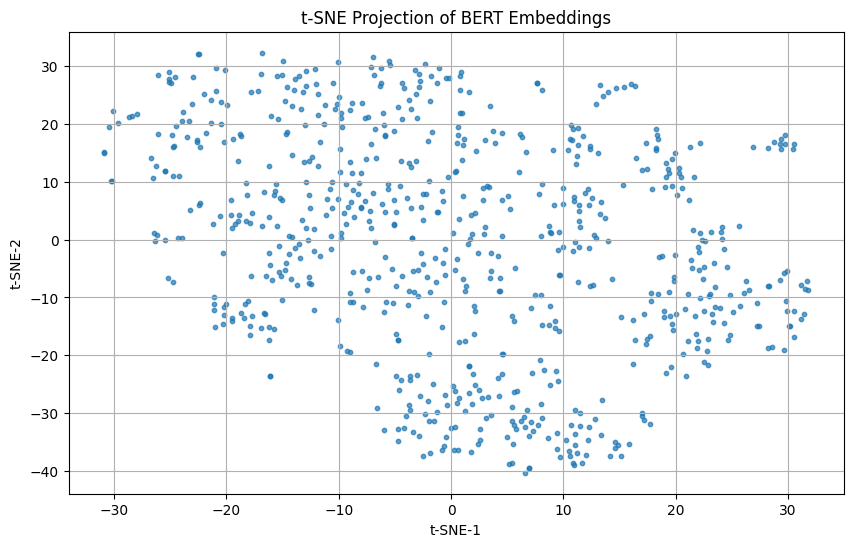

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Apply t-SNE to the BERT embeddings
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
embedding_2d_tsne = tsne.fit_transform(bert_embeddings)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(embedding_2d_tsne[:, 0], embedding_2d_tsne[:, 1], s=10, alpha=0.7)
plt.title("t-SNE Projection of BERT Embeddings")
plt.xlabel("t-SNE-1")
plt.ylabel("t-SNE-2")
plt.grid(True)
plt.show()


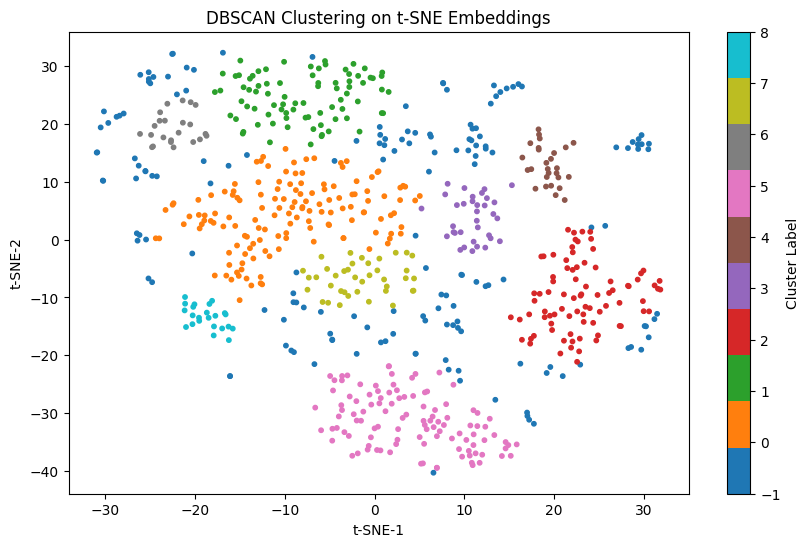

In [ ]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import numpy as np

# Run DBSCAN on the 2D t-SNE projection
dbscan = DBSCAN(eps=4, min_samples=15)
cluster_labels = dbscan.fit_predict(embedding_2d_tsne)

# Visualize clusters
plt.figure(figsize=(10, 6))
plt.scatter(embedding_2d_tsne[:, 0], embedding_2d_tsne[:, 1], c=cluster_labels, cmap='tab10', s=10)
plt.title("DBSCAN Clustering on t-SNE Embeddings")
plt.xlabel("t-SNE-1")
plt.ylabel("t-SNE-2")
plt.colorbar(label="Cluster Label")
plt.show()


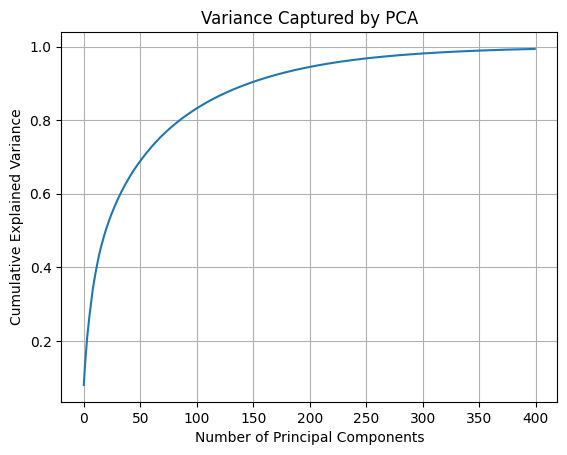

Reduced shape: (725, 400)


In [ ]:
from sklearn.decomposition import PCA

# Reduce to, say, 100 dimensions
pca = PCA(n_components=400)
bert_embeddings_reduced = pca.fit_transform(bert_embeddings)


explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.plot(np.arange(0, 400), explained_variance)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Variance Captured by PCA')
plt.grid(True)
plt.show()

print("Reduced shape:", bert_embeddings_reduced.shape)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP-reduced shape: (725, 300)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


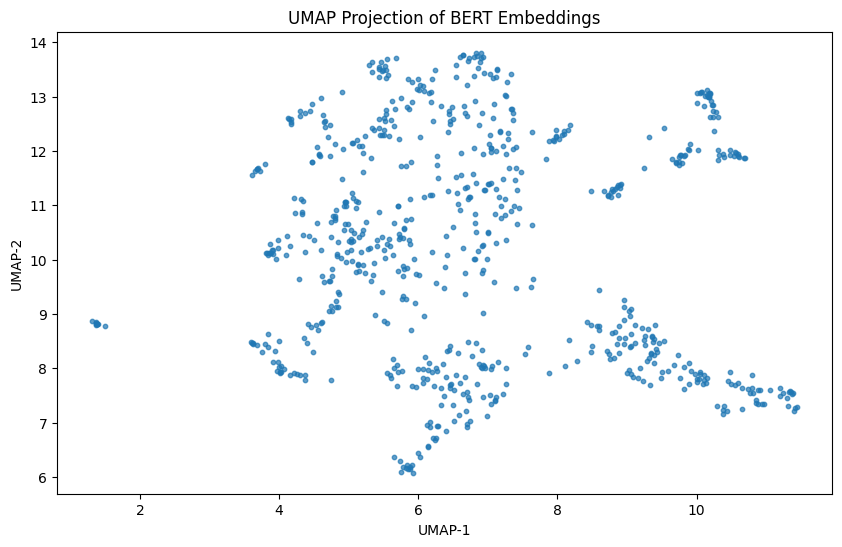

In [ ]:
%pip install umap-learn
import umap
import numpy as np

# Reduce to e.g., 50 or 100 dimensions
umap_reducer = umap.UMAP(n_components=300, random_state=42)
bert_embeddings_reduced = umap_reducer.fit_transform(bert_embeddings)

print("UMAP-reduced shape:", bert_embeddings_reduced.shape)

import matplotlib.pyplot as plt

umap_2d = umap.UMAP(n_components=2, random_state=42)
embedding_2d = umap_2d.fit_transform(bert_embeddings)

plt.figure(figsize=(10, 6))
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], s=10, alpha=0.7)
plt.title("UMAP Projection of BERT Embeddings")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


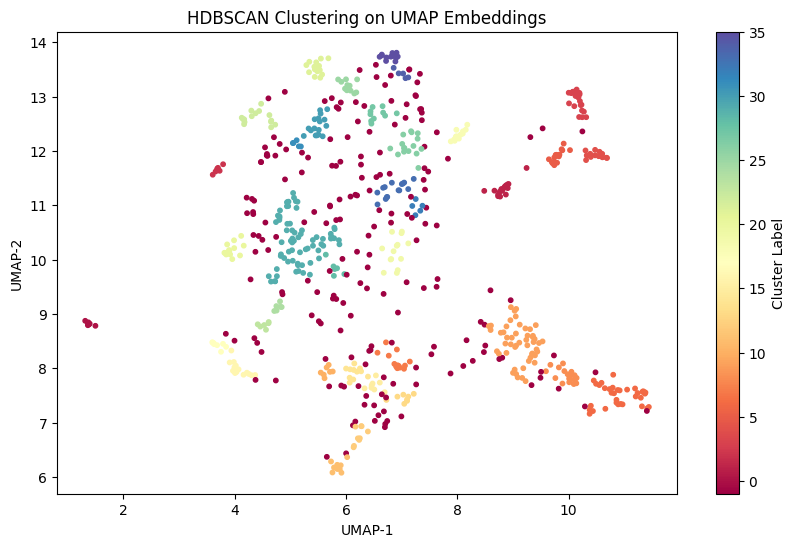

In [ ]:
%pip install hdbscan
import hdbscan
import matplotlib.pyplot as plt

# Fit HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, prediction_data=True)
cluster_labels = clusterer.fit_predict(embedding_2d)

# Plot with color-coded clusters
plt.figure(figsize=(10, 6))
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=cluster_labels, cmap='Spectral', s=10)
plt.title("HDBSCAN Clustering on UMAP Embeddings")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.colorbar(label='Cluster Label')
plt.show()


In [ ]:
import numpy as np
y_train_arr = np.array(y_train_bert)
y_test_arr = np.array(y_test_bert)

In [ ]:
# import matplotlib.pyplot as plt

# explained = svd.explained_variance_ratio_
# plt.plot(range(1, len(explained)+1), explained.cumsum())
# plt.xlabel("Number of Components")
# plt.ylabel("Cumulative Explained Variance")
# plt.title("Explained Variance by TruncatedSVD")
# plt.grid(True)
# plt.show()

In [ ]:
import numpy as np
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, hamming_loss, f1_score, classification_report)

# ------------------------------------------------
# (Optional) Define a function to optimize thresholds per class by F1
# ------------------------------------------------
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def optimize_global_threshold_for_f1(y_true, y_proba, average='macro'):
    """
    Searches a single threshold t that maximizes the *average F1* (macro or micro) across all classes.

    y_true: 2D array, shape (n_samples, n_classes), true 0/1 labels
    y_proba: 2D array, shape (n_samples, n_classes), predicted probabilities
    average: 'micro' or 'macro' (or 'weighted') for how to aggregate F1

    Returns:
      best_thr: float, the single best threshold
      best_score: float, the F1 score achieved at that threshold
    """
    thresholds = np.linspace(0.1, 0.9, 101)  # e.g. 0.00, 0.01, ..., 1.00
    best_score = -1.0
    best_thr = 0.5
    best_thresholds = []
    for i in range(y_true.shape[1]):
      thresholds = np.linspace(0.1, 0.9, 101)
      best_t = 0.5
      best_score = -1
      for t in thresholds:
          # Binarize all classes at once
          test_thresholds = np.ones(y_true.shape[1]) * 0.5
          test_thresholds[i] = t
          y_pred = (y_proba >= test_thresholds).astype(int)
          # Compute F1 across *all* classes
          micro_score = f1_score(y_true, y_pred, average='micro', zero_division=0)
          macro_score = f1_score(y_true, y_pred, average='macro', zero_division=0)
          weighted_score = f1_score(y_true, y_pred, average='weighted', zero_division=0)
          score = np.mean([micro_score, macro_score])  # Average of all F1s
          if score > best_score:
              best_score = score
              best_t = t
      best_thresholds.append(best_t)
    best_thresholds = np.array(best_thresholds)
    return best_thresholds, best_score

y_train_transformed = np.array(y_train_arr.tolist())
y_test_transformed = np.array(y_test_arr.tolist())
# ------------------------------------------------
# 1) Identify and remove "dead" labels (always 0 or always 1 in training)
# ------------------------------------------------
train_sums = y_train_transformed.sum(axis=0)          # sum of each column
n_train = y_train_transformed.shape[0]                # total training samples

# Dead labels are those with sum==0 or sum==n_train
dead_mask = (train_sums == 0) | (train_sums == n_train)
alive_mask = ~dead_mask

print("Dead labels (columns):", np.where(dead_mask)[0])
print("Keeping labels (columns):", np.where(alive_mask)[0])

y_train_filtered = y_train_transformed[:, alive_mask]
y_test_filtered = y_test_transformed[:, alive_mask]

print("Original shape (train):", y_train_transformed.shape)
print("Filtered shape (train):", y_train_filtered.shape)


# ------------------------------------------------
# 2) Train the model on the filtered labels
# ------------------------------------------------
clf_bert = OneVsRestClassifier(
    LogisticRegression(C=10.0, max_iter=1000, class_weight='balanced')
)
clf_bert.fit(X_train_bert, y_train_filtered)


# ------------------------------------------------
# 3) Predict probabilities on test set
# ------------------------------------------------
y_pred_proba = clf_bert.predict_proba(X_test_bert)  # shape: (n_test_samples, #alive_classes)


# ------------------------------------------------
# 4) (Optional) Optimize thresholds per class (F1)
# ------------------------------------------------
best_thr, best_f1 = optimize_global_threshold_for_f1(y_test_filtered, y_pred_proba, average='macro')
print(best_thr)

# Final predictions:
y_pred = (y_pred_proba >= best_thr).astype(int)

# ------------------------------------------------
# 5) Evaluate on the filtered labels
# ------------------------------------------------
exact_match = accuracy_score(y_test_filtered, y_pred)  # same as "subset accuracy"
h_loss = hamming_loss(y_test_filtered, y_pred)
f1_micro = f1_score(y_test_filtered, y_pred, average='micro', zero_division=0)
f1_macro = f1_score(y_test_filtered, y_pred, average='macro', zero_division=0)

label_frequencies = y_train_filtered.sum(axis=0)
print("Label Frequencies:", label_frequencies)

print("\n===== Filtered BERT Classifier Evaluation =====")
print(f"Exact Match Accuracy: {exact_match:.4f}")
print(f"Hamming Loss: {h_loss:.4f}")
print(f"F1 Score (micro): {f1_micro:.4f}")
print(f"F1 Score (macro): {f1_macro:.4f}")
print(classification_report(y_test_filtered, y_pred, zero_division=0))

# If you have filtered class names, pass them here
# Otherwise, just show numeric class indices
print("\n--- Per-Class Metrics (Filtered) ---")
print(classification_report(y_test_filtered, y_pred, zero_division=0))


Dead labels (columns): [2]
Keeping labels (columns): [ 0  1  3  4  5  6  7  8  9 10 11 12 13]
Original shape (train): (580, 14)
Filtered shape (train): (580, 13)
[0.62  0.292 0.388 0.708 0.492 0.516 0.588 0.388 0.852 0.164 0.844 0.588
 0.756]
Label Frequencies: [68 51 32 72 20 36 65  4 22 12 97 98 62]

===== Filtered BERT Classifier Evaluation =====
Exact Match Accuracy: 0.3931
Hamming Loss: 0.0679
F1 Score (micro): 0.5975
F1 Score (macro): 0.6395
              precision    recall  f1-score   support

           0       0.64      0.69      0.67        13
           1       0.41      0.92      0.57        13
           2       0.67      0.67      0.67         6
           3       0.62      0.62      0.62         8
           4       1.00      0.60      0.75        10
           5       0.67      0.74      0.70        19
           6       0.38      0.47      0.42        19
           7       1.00      1.00      1.00         1
           8       1.00      0.50      0.67         2
       

In [ ]:
# First, let's inspect the actual format of your labels
print("Type of y_train_bert:", type(y_train_bert))
if hasattr(y_train_bert, 'iloc'):
    print("Sample labels (first 3):")
    print(y_train_bert.iloc[:3])
else:
    print("Sample labels (first 3):")
    print(y_train_bert[:3])

# Check if the labels are already in a binary format
if isinstance(y_train_bert.iloc[0] if hasattr(y_train_bert, 'iloc') else y_train_bert[0], list):
    print("Labels appear to be in a list format")
    # Check a sample label
    sample = y_train_bert.iloc[0] if hasattr(y_train_bert, 'iloc') else y_train_bert[0]
    print("Sample label:", sample)
    print("Type of elements in the label:", type(sample[0]) if len(sample) > 0 else "empty")
elif hasattr(y_train_bert.iloc[0] if hasattr(y_train_bert, 'iloc') else y_train_bert[0], 'shape'):
    print("Labels appear to be already binarized")
    # Check shape of a sample label
    sample = y_train_bert.iloc[0] if hasattr(y_train_bert, 'iloc') else y_train_bert[0]
    print("Shape of sample label:", sample.shape)

Type of y_train_bert: <class 'pandas.core.series.Series'>
Sample labels (first 3):
446    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
6      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...
423    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: labels, dtype: object
Labels appear to be in a list format
Sample label: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Type of elements in the label: <class 'int'>


In [ ]:
import pandas as pd
import numpy as np
probs = clf.predict_proba(X_test)
probs
df = pd.DataFrame(probs)
# df = pd.DataFrame(y_test_arr)
df

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.135752,0.033313,0.008193,0.006614,0.008832,0.016744,0.004168,0.014345,0.043044,0.002493,...,0.544877,0.004548,0.382311,0.033416,0.003244,0.012055,0.176468,0.005665,0.327419,0.003592
1,0.126278,0.135972,0.004331,0.004693,0.004522,0.024828,0.002322,0.006474,0.013275,0.002653,...,0.004290,0.003126,0.935018,0.009241,0.003807,0.002486,0.014775,0.002207,0.194494,0.003220
2,0.088133,0.063320,0.006604,0.006072,0.004891,0.012014,0.003679,0.008700,0.032715,0.002898,...,0.350163,0.004434,0.097025,0.033621,0.002917,0.007640,0.050306,0.009926,0.049777,0.003917
3,0.133445,0.325604,0.008652,0.009042,0.058012,0.020868,0.002997,0.009156,0.089040,0.003890,...,0.403647,0.003522,0.017607,0.011041,0.005231,0.009214,0.036150,0.002173,0.010482,0.005226
4,0.052589,0.019559,0.008749,0.004495,0.007842,0.014203,0.003243,0.007236,0.022023,0.002362,...,0.935323,0.003453,0.103813,0.011365,0.004127,0.005813,0.036230,0.009793,0.069816,0.003548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,0.131286,0.169231,0.006109,0.007451,0.003424,0.036788,0.003076,0.003829,0.023169,0.002183,...,0.063901,0.003571,0.012016,0.004721,0.002907,0.003979,0.030436,0.002748,0.016319,0.004164
141,0.346138,0.099304,0.007405,0.009041,0.012243,0.054842,0.003135,0.017227,0.040427,0.038701,...,0.046462,0.004146,0.027554,0.009718,0.003351,0.007203,0.181282,0.016206,0.071714,0.004847
142,0.142710,0.188873,0.015243,0.021931,0.004802,0.086861,0.003846,0.009316,0.089122,0.003279,...,0.876177,0.004631,0.217748,0.069137,0.008873,0.021818,0.059505,0.001934,0.024191,0.005735
143,0.901903,0.016767,0.006816,0.010406,0.004574,0.009731,0.003442,0.019984,0.064854,0.002596,...,0.116875,0.006406,0.028767,0.030962,0.004099,0.016633,0.033132,0.003927,0.043308,0.004306
